# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнила: Солодова София
###### Группа: М8О-309Б-23
###### Датасет (ссылка): https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

---

In [ ]:
# Main libs for data
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
)
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install catboost

In [ ]:
# data paths
file_path = r"C:\Users\Raicer\Downloads\cardio_train.csv"

In [ ]:
# mount gDrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к файлу датасета
file_path = Path('/content/drive/MyDrive/Colab_Notebooks/ML_laba_3/cardio_train.csv')

In [ ]:
df = pd.read_csv(file_path, sep=";")
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
def clean_cardio_data(df):
    """
    Комплексная очистка датасета Cardio
    """
    df_clean = df.copy()

    print("НАЧАЛО ОЧИСТКИ ДАННЫХ")
    print(f"Исходный размер: {df.shape}")

    # =========================================================================
    # 1. ОЧИСТКА ДАВЛЕНИЯ (ap_hi, ap_lo) - ЗАМЕНЯЕМ исходные данные
    # =========================================================================
    print("\n1. ОЧИСТКА ДАВЛЕНИЯ:")

    original_count = len(df_clean)

    # Фильтруем физиологически невозможные значения
    pressure_mask = (
        (df_clean['ap_hi'] >= 50) & (df_clean['ap_hi'] <= 300) &
        (df_clean['ap_lo'] >= 30) & (df_clean['ap_lo'] <= 200) &
        (df_clean['ap_hi'] > df_clean['ap_lo'])
    )

    df_clean = df_clean[pressure_mask]
    print(f"   Удалено строк по давлению: {original_count - len(df_clean)}")

    # =========================================================================
    # 2. ОЧИСТКА ВОЗРАСТА - ЗАМЕНЯЕМ исходный столбец
    # =========================================================================
    print("\n2. ОЧИСТКА ВОЗРАСТА:")

    # Переводим в годы и ЗАМЕНЯЕМ исходный столбец
    df_clean['age'] = df_clean['age'] / 365.25  # ПЕРЕЗАПИСЫВАЕМ возраст

    # Фильтруем по возрасту (30-65 лет)
    age_mask = (df_clean['age'] >= 30) & (df_clean['age'] <= 65)
    df_clean = df_clean[age_mask]
    print(f"   Возрастной диапазон: {df_clean['age'].min():.1f}-{df_clean['age'].max():.1f} лет")

    # =========================================================================
    # 3. ОЧИСТКА РОСТА И ВЕСА - используем исходные столбцы
    # =========================================================================
    print("\n3. ОЧИСТКА РОСТА И ВЕСА:")

    # Рост: 150-200 см
    height_mask = (df_clean['height'] >= 150) & (df_clean['height'] <= 200)

    # Вес: 40-150 кг
    weight_mask = (df_clean['weight'] >= 40) & (df_clean['weight'] <= 150)

    df_clean = df_clean[height_mask & weight_mask]
    print(f"   Рост: {df_clean['height'].min()}-{df_clean['height'].max()} см")
    print(f"   Вес: {df_clean['weight'].min()}-{df_clean['weight'].max()} кг")

    # =========================================================================
    # 4. РАСЧЕТ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ (эти можно оставить новыми)
    # =========================================================================
    print("\n4. РАСЧЕТ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ:")

    # Индекс массы тела (ИМТ) - новый признак
    df_clean['bmi'] = df_clean['weight'] / ((df_clean['height'] / 100) ** 2)

    # Пульсовое давление - новый признак
    df_clean['pulse_pressure'] = df_clean['ap_hi'] - df_clean['ap_lo']

    print(f"   ИМТ: {df_clean['bmi'].min():.1f}-{df_clean['bmi'].max():.1f}")

    # =========================================================================
    # 5. ФИНАЛЬНАЯ ПРОВЕРКА
    # =========================================================================
    print("\n5. ФИНАЛЬНАЯ СТАТИСТИКА:")
    print(f"   Исходный размер: {df.shape}")
    print(f"   После очистки: {df_clean.shape}")
    print(f"   Удалено строк: {len(df) - len(df_clean)} ({((len(df) - len(df_clean)) / len(df) * 100):.1f}%)")

    return df_clean
df_clean = clean_cardio_data(df)

df_clean = df_clean.sample(n=10000, random_state=30)  # ровно 10к строк
print(f"Оставили ровно {len(df_clean)} строк")

НАЧАЛО ОЧИСТКИ ДАННЫХ
Исходный размер: (70000, 13)

1. ОЧИСТКА ДАВЛЕНИЯ:
   Удалено строк по давлению: 1322

2. ОЧИСТКА ВОЗРАСТА:
   Возрастной диапазон: 30.0-64.9 лет

3. ОЧИСТКА РОСТА И ВЕСА:
   Рост: 150-198 см
   Вес: 40.0-150.0 кг

4. РАСЧЕТ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ:
   ИМТ: 13.5-59.3

5. ФИНАЛЬНАЯ СТАТИСТИКА:
   Исходный размер: (70000, 13)
   После очистки: (67093, 15)
   Удалено строк: 2907 (4.2%)
Оставили ровно 10000 строк


In [ ]:
if 'id' in df_clean.columns:
    df_clean = df_clean.drop(columns=['id'])
df_clean.head(2)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
29888,58.390144,1,164,63.0,120,80,1,1,0,0,1,0,23.423557,40
41701,55.652293,1,175,55.0,140,80,2,1,0,0,1,1,17.959184,60


In [ ]:
df_clean = df_clean.reset_index(drop=True)
df_clean.head(2)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
0,58.390144,1,164,63.0,120,80,1,1,0,0,1,0,23.423557,40
1,55.652293,1,175,55.0,140,80,2,1,0,0,1,1,17.959184,60


делим на test и train

In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_clean.drop('cardio', axis=1), df_clean['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создаем пайплайн

In [ ]:
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('classifier', CatBoostClassifier(random_state=42, verbose=False))
])

# Просмотр пайплайна
pipeline

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f25d7b94740>)])

Параметры для перебора для методов:

* Grid Search
* Random Search


## Таблица гиперпараметров CatBoost:

| Параметр | Влияние на модель | Назначение | Диапазон значений |
|----------|-------------------|------------|-------------------|
| **iterations** | Борьба с недо/переобучением | Количество деревьев в ансамбле. Увеличивает точность, но требует больше вычислительных ресурсов | 100-2000 |
| **learning_rate** | Скорость сходимости | Темп обучения. Меньшие значения повышают качество, но требуют больше итераций | 0.01-0.3 |
| **depth** | Сложность модели | Глубина деревьев. Большие значения capture сложные зависимости, но могут привести к переобучению | 4-10 |
| **l2_leaf_reg** | Регуляризация | Коэффициент L2-регуляризации. Снижает переобучение через штраф за сложность | 1-10 |
| **random_strength** | Стабильность | Уровень случайности при выборе разделений. Повышает Robustness модели | 0.1-10 |
| **bagging_temperature** | Стохастичность | Контролирует интенсивность бутстрэппинга. 0 - детерминированный режим | 0-2 |
| **grow_policy** | Архитектура деревьев | Стратегия роста: SymmetricTree или Lossguide для оптимизации потерь | "SymmetricTree", "Lossguide" |
| **min_data_in_leaf** | Регуляризация | Минимальное количество samples в листе. Защита от переобучения на шумных данных | 1-20 |
| **max_leaves** | Сложность модели | Максимальное количество листьев (только для Lossguide). Увеличивает Capacity модели | 16-128 |
| **subsample** | Дисперсия | Доля samples для обучения каждого дерева. Снижает Variance через рандомизацию | 0.6-1.0 |
| **bootstrap_type** | Метод выборки | Техника бутстрэппинга: Bayesian для адаптивности, Bernoulli для простоты | "Bayesian", "Bernoulli" |
| **scale_pos_weight** | Баланс классов | Вес положительного класса для несбалансированных данных. Критичен для skewed распределений | 1-10 |
| **eval_metric** | Оптимизация | Метрика для валидации и ранней остановки. Должна соответствовать задаче | "Accuracy", "F1", "AUC" |
| **loss_function** | Целевая функция | Функция потерь для оптимизации. Logloss для бинарной классификации | "Logloss", "CrossEntropy" |
| **border_count** | Дискретизация | Количество бинов для числовых признаков. Влияет на granularity разбиений | 32-255 |
| **feature_border_type** | Квантование | Метод дискретизации признаков. Влияет на качество на complex распределениях | "Median", "GreedyLogSum" |



In [ ]:
# =============================================================================
# НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ ДЛЯ ПОДБОРА
# =============================================================================

# -----------------------------------------------------------------------------
# БАЗОВЫЙ НАБОР ПАРАМЕТРОВ (для GridSearch - небольшой для скорости)
# -----------------------------------------------------------------------------
param_grid_basic = {
    # Основные параметры бустинга
    "classifier__iterations": [300, 500, 700],           # Количество деревьев
    "classifier__learning_rate": [0.01, 0.03, 0.05],     # Темп обучения
    "classifier__depth": [4, 6, 8],                      # Глубина деревьев

    # Регуляризация для борьбы с переобучением
    "classifier__l2_leaf_reg": [1, 3, 5],               # L2-регуляризация
    "classifier__random_strength": [1, 2],               # Случайность при выборе разделений
}

# -----------------------------------------------------------------------------
# РАСШИРЕННЫЙ НАБОР ПАРАМЕТРОВ (для RandomSearch - больше вариантов)
# -----------------------------------------------------------------------------
param_grid_advanced = {
    # Основные параметры бустинга
    "classifier__iterations": [200, 400, 600, 800, 1000],
    "classifier__learning_rate": [0.005, 0.01, 0.03, 0.05, 0.07],
    "classifier__depth": [4, 6, 8, 10],

    # Регуляризация
    "classifier__l2_leaf_reg": [1, 3, 5, 7, 10],
    "classifier__random_strength": [0.5, 1, 2, 5],

    # Стохастичность и бэггинг
    "classifier__subsample": [0.7, 0.8, 0.9, 1.0],      # Доля данных для каждого дерева
    "classifier__bagging_temperature": [0, 0.5, 1],     # Интенсивность бутстрэппинга

}

'''
param_grid_comprehensive = {
    # Основные параметры бустинга
    "classifier__iterations": [100, 200, 300, 500, 700, 1000, 1500],
    "classifier__learning_rate": [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15],
    "classifier__depth": [3, 4, 5, 6, 7, 8, 9, 10, 12],

    # Регуляризация
    "classifier__l2_leaf_reg": [0.1, 0.5, 1, 2, 3, 5, 7, 10, 15, 20],
    "classifier__random_strength": [0.1, 0.5, 1, 2, 5, 10, 20],

    # Стохастичность
    "classifier__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__bagging_temperature": [0, 0.1, 0.3, 0.5, 0.7, 1, 2, 5],

    # Построение деревьев
    "classifier__grow_policy": ["SymmetricTree", "Lossguide"],
    "classifier__min_data_in_leaf": [1, 2, 5, 10, 15, 20],
    "classifier__max_leaves": [16, 31, 63, 127],

    # Обработка признаков
    "classifier__border_count": [32, 64, 128, 254],
    "classifier__feature_border_type": ["Median", "GreedyLogSum"],

    # Балансировка
    "classifier__scale_pos_weight": [0.5, 1, 2, 3, 5],
    "classifier__auto_class_weights": ["Balanced", "SqrtBalanced", None],
}
'''


'\nparam_grid_comprehensive = {\n    # Основные параметры бустинга\n    "classifier__iterations": [100, 200, 300, 500, 700, 1000, 1500],\n    "classifier__learning_rate": [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15],\n    "classifier__depth": [3, 4, 5, 6, 7, 8, 9, 10, 12],\n\n    # Регуляризация\n    "classifier__l2_leaf_reg": [0.1, 0.5, 1, 2, 3, 5, 7, 10, 15, 20],\n    "classifier__random_strength": [0.1, 0.5, 1, 2, 5, 10, 20],\n\n    # Стохастичность\n    "classifier__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n    "classifier__bagging_temperature": [0, 0.1, 0.3, 0.5, 0.7, 1, 2, 5],\n\n    # Построение деревьев\n    "classifier__grow_policy": ["SymmetricTree", "Lossguide"],\n    "classifier__min_data_in_leaf": [1, 2, 5, 10, 15, 20],\n    "classifier__max_leaves": [16, 31, 63, 127],\n\n    # Обработка признаков\n    "classifier__border_count": [32, 64, 128, 254],\n    "classifier__feature_border_type": ["Median", "GreedyLogSum"],\n\n    # Балансировка\n    "classifier__scale_pos_weigh

# Grid Search
- Перебирает все возможные комбинации указанных гиперпараметров.
- Для каждой комбинации обучает модель и проверяет качество на кросс-валидации.
- Возвращает лучшую комбинацию по заданной метрике (например, accuracy).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# =============================================================================
# GRID SEARCH ПОДБОР ГИПЕРПАРАМЕТРОВ
# =============================================================================

# Создание объекта GridSearchCV
gs_tree = GridSearchCV(
    estimator=pipeline,           # наш пайплайн с CatBoost
    param_grid=param_grid_basic,  # используем базовый набор параметров
    scoring="roc_auc",           #  ROC-AUC
    cv=5,                         # 5-кратная кросс-валидация
    n_jobs=-1,                    # использование всех доступных ядер процессора
    verbose=3,                    # подробный вывод процесса подбора
    refit=True                    # автоматическая дообучение на всех данных
)

# Обучение и подбор параметров
print("Запуск GridSearch...")
gs_tree.fit(X_train, y_train)

# =============================================================================
# ВЫВОД РЕЗУЛЬТАТОВ
# =============================================================================

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ GRID SEARCH")
print("="*50)

print("\n ЛУЧШИЕ ПАРАМЕТРЫ:")
for key, value in gs_tree.best_params_.items():
    clean_key = key.replace('classifier__', '')
    print(f'  {clean_key}: {value}')

print(f"\n ЛУЧШЕЕ КАЧЕСТВО НА КРОСС-ВАЛИДАЦИИ (ROC-AUC): {gs_tree.best_score_:.4f}")

# Предсказание на тестовой выборке
y_pred = gs_tree.predict(X_test)
y_pred_proba = gs_tree.predict_proba(X_test)[:, 1]  # вероятности для ROC-AUC

# МЕТРИКИ ДЛЯ МЕДИЦИНЫ:
test_accuracy = gs_tree.score(X_test, y_test)
test_auc = roc_auc_score(y_test, y_pred_proba)  # ROC-AUC на тесте

print(f"ROC-AUC НА ТЕСТОВОЙ ВЫБОРКЕ: {test_auc:.4f}")
print(f"Accuracy НА ТЕСТОВОЙ ВЫБОРКЕ: {test_accuracy:.4f}")

# Детальный отчет
print("\nДЕТАЛЬНЫЙ ОТЧЕТ:")
print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

# =============================================================================
# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
# =============================================================================

print(f"\nВСЕГО ПРОТЕСТИРОВАНО КОМБИНАЦИЙ: {len(gs_tree.cv_results_['params'])}")
print(f"ЛУЧШАЯ КОМБИНАЦИЯ НАЙДЕНА НА FOLD: {gs_tree.best_index_ + 1}")

# Вывод топ-5 лучших комбинаций
print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
results_df = pd.DataFrame(gs_tree.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Параметры: {row['params']}")
    print()

Запуск GridSearch...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

РЕЗУЛЬТАТЫ GRID SEARCH

 ЛУЧШИЕ ПАРАМЕТРЫ:
  depth: 4
  iterations: 500
  l2_leaf_reg: 1
  learning_rate: 0.01
  random_strength: 1

 ЛУЧШЕЕ КАЧЕСТВО НА КРОСС-ВАЛИДАЦИИ (ROC-AUC): 0.8082
ROC-AUC НА ТЕСТОВОЙ ВЫБОРКЕ: 0.7770
Accuracy НА ТЕСТОВОЙ ВЫБОРКЕ: 0.7770

ДЕТАЛЬНЫЙ ОТЧЕТ:
              precision    recall  f1-score   support

      Здоров       0.68      0.78      0.73      1001
       Болен       0.74      0.63      0.68       999

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.70      2000
weighted avg       0.71      0.71      0.70      2000


ВСЕГО ПРОТЕСТИРОВАНО КОМБИНАЦИЙ: 162
ЛУЧШАЯ КОМБИНАЦИЯ НАЙДЕНА НА FOLD: 19

ТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:
1. ROC-AUC: 0.8082 (±0.0063)
   Параметры: {'classifier__depth': 4, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.01, 'classifier__random_strength': 1}

По результатам GridSearch получена модель CatBoost с ROC-AUC 0.8082 на кросс-валидации и 0.7770 на тестовой выборке. Качество модели можно оценить как хорошее для медицинских данных, при этом наблюдается умеренное падение метрики на тесте, что указывает на незначительное переобучение. Найденные гиперпараметры демонстрируют консервативный подход: глубина деревьев 4, низкая скорость обучения 0.01 и слабая регуляризация, что обеспечивает стабильность модели. GridSearch эффективно исследовал 162 комбинации параметров, при этом топ-5 лучших конфигураций показали очень близкие результаты (ROC-AUC 0.8081-0.8082), что свидетельствует о широком плато качественных решений в пространстве параметров. Данный результат представляет собой надежную базовую модель для прогнозирования сердечно-сосудистых заболеваний.

# Random Search

* **Идея:** выбираем случайные комбинации гиперпараметров из заранее определённых диапазонов.
* **Плюсы:**
  * Прост в реализации.
  * Эффективнее, чем Grid Search для моделей с большим числом гиперпараметров.
  * Хорош для грубой оценки влияния гиперпараметров.
* **Минусы:**
  * Не гарантирует нахождение оптимального решения.
  * Требует большого числа итераций при сложных пространствах гиперпараметров.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# =============================================================================
# RANDOM SEARCH ПОДБОР ГИПЕРПАРАМЕТРОВ
# =============================================================================

random_search = RandomizedSearchCV(
    estimator=pipeline,                    # наш пайплайн с CatBoost
    param_distributions=param_grid_advanced,  # расширенный набор параметров
    n_iter=48,                            # количество случайных комбинаций
    scoring='roc_auc',                    # ROC-AUC
    cv=5,                                 # 5-кратная кросс-валидация
    n_jobs=-1,                            # использование всех доступных ядер
    verbose=3,                            # подробный вывод процесса подбора
    random_state=42,                      # для воспроизводимости результатов
    refit=True                            # автоматическая дообучение на всех данных
)

print("Запуск RandomSearch...")
random_search.fit(X_train, y_train)

# =============================================================================
# ВЫВОД РЕЗУЛЬТАТОВ
# =============================================================================

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ RANDOM SEARCH")
print("="*50)

print("\nЛУЧШИЕ ПАРАМЕТРЫ:")
for key, value in random_search.best_params_.items():
    clean_key = key.replace('classifier__', '')
    print(f'  {clean_key}: {value}')

print(f"\nЛУЧШИЙ ROC-AUC НА КРОСС-ВАЛИДАЦИИ: {random_search.best_score_:.4f}")

# Предсказание на тестовой выборке
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

# МЕТРИКИ ДЛЯ МЕДИЦИНЫ:
test_accuracy = random_search.score(X_test, y_test)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC НА ТЕСТОВОЙ ВЫБОРКЕ: {test_auc:.4f}")
print(f"Accuracy НА ТЕСТОВОЙ ВЫБОРКЕ: {test_accuracy:.4f}")

# Детальный отчет
print("\nДЕТАЛЬНЫЙ ОТЧЕТ:")
print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

# =============================================================================
# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
# =============================================================================

print(f"\nВСЕГО ПРОТЕСТИРОВАНО СЛУЧАЙНЫХ КОМБИНАЦИЙ: {len(random_search.cv_results_['params'])}")
print(f"ЛУЧШАЯ КОМБИНАЦИЯ НАЙДЕНА НА ИТЕРАЦИИ: {random_search.best_index_ + 1}")

# Анализ распределения результатов
scores = random_search.cv_results_['mean_test_score']
print(f"СРЕДНИЙ ROC-AUC ВСЕХ КОМБИНАЦИЙ: {np.mean(scores):.4f}")
print(f"МАКСИМАЛЬНЫЙ ROC-AUC: {np.max(scores):.4f}")
print(f"МИНИМАЛЬНЫЙ ROC-AUC: {np.min(scores):.4f}")
print(f"СТАНДАРТНОЕ ОТКЛОНЕНИЕ: {np.std(scores):.4f}")

# Вывод топ-5 лучших комбинаций
print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
results_df = pd.DataFrame(random_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    # Сокращенный вывод параметров для читаемости
    params_short = {k: v for k, v in row['params'].items() if 'classifier__' in k}
    print(f"   Параметры: {params_short}")
    print()

Запуск RandomSearch...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

РЕЗУЛЬТАТЫ RANDOM SEARCH

ЛУЧШИЕ ПАРАМЕТРЫ:
  subsample: 0.8
  random_strength: 1
  learning_rate: 0.005
  l2_leaf_reg: 3
  iterations: 1000
  depth: 4
  bagging_temperature: 0

ЛУЧШИЙ ROC-AUC НА КРОСС-ВАЛИДАЦИИ: 0.8080
ROC-AUC НА ТЕСТОВОЙ ВЫБОРКЕ: 0.7772
Accuracy НА ТЕСТОВОЙ ВЫБОРКЕ: 0.7772

ДЕТАЛЬНЫЙ ОТЧЕТ:
              precision    recall  f1-score   support

      Здоров       0.68      0.78      0.73      1001
       Болен       0.74      0.63      0.68       999

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.70      2000
weighted avg       0.71      0.71      0.70      2000


ВСЕГО ПРОТЕСТИРОВАНО СЛУЧАЙНЫХ КОМБИНАЦИЙ: 48
ЛУЧШАЯ КОМБИНАЦИЯ НАЙДЕНА НА ИТЕРАЦИИ: 17
СРЕДНИЙ ROC-AUC ВСЕХ КОМБИНАЦИЙ: 0.8002
МАКСИМАЛЬНЫЙ ROC-AUC: 0.8080
МИНИМАЛЬНЫЙ ROC-AUC: 0.7748
СТАНДАРТНОЕ ОТКЛОНЕНИЕ: 0.0076

ТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:
1. ROC-AUC: 0.8080 (±0

Random Search показал эффективность, найдя оптимальные параметры всего за 17 итераций из 48. ROC-AUC 0.8080 на валидации и 0.7772 на тесте практически совпадает с результатами GridSearch, что подтверждает надежность модели. Настройки получились консервативными: низкая скорость обучения 0.005, глубина 4-6, что обеспечивает стабильность. Метод продемонстрировал сопоставимое с GridSearch качество при меньших вычислительных затратах.

# Байесовская оптимизация с Optuna

* **Идея:** строим вероятностную модель функции потерь и используем её, чтобы выбирать новые гиперпараметры «умнее», чем случайно.
* **Плюсы:**
  * Эффективнее Random Search при сложных пространствах гиперпараметров.
  * Балансирует *exploration* (исследование) и *exploitation* (использование лучших областей).
* **Минусы:**
  * Сложнее для понимания и настройки.
  * Требует больше зависимостей (Optuna, иногда PyTorch/Scikit-learn).

[Подробнее](https://optuna.org/)

In [ ]:
# Установка Optuna
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report

# =============================================================================
# OPTUNA ПОДБОР ГИПЕРПАРАМЕТРОВ
# =============================================================================

def objective_cb(trial):
    """
    Функция для оптимизации гиперпараметров с помощью Optuna
    """
    # Настройка гиперпараметров для CatBoost
    iterations = trial.suggest_int("classifier__iterations", 300, 1200)
    learning_rate = trial.suggest_float("classifier__learning_rate", 0.01, 0.1)
    depth = trial.suggest_int("classifier__depth", 4, 10)
    l2_leaf_reg = trial.suggest_float("classifier__l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("classifier__random_strength", 0.5, 5)
    subsample = trial.suggest_float("classifier__subsample", 0.7, 1.0)

    # Устанавливаем параметры в pipeline
    pipeline.set_params(
        classifier__iterations=iterations,
        classifier__learning_rate=learning_rate,
        classifier__depth=depth,
        classifier__l2_leaf_reg=l2_leaf_reg,
        classifier__random_strength=random_strength,
        classifier__subsample=subsample
    )

    # 5-fold cross-validation с ROC-AUC
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score


# Создаём исследование Optuna
study_cb = optuna.create_study(
    direction='maximize',  # максимизируем ROC-AUC
    study_name="catboost_optimization"
)

print("Запуск Optuna optimization...")
study_cb.optimize(
    objective_cb,
    n_trials=48,  # количество испытаний
    n_jobs=-1,     # параллельные вычисления
    show_progress_bar=True  # визуализация прогресса
)

# =============================================================================
# ВЫВОД РЕЗУЛЬТАТОВ
# =============================================================================

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ OPTUNA OPTIMIZATION")
print("="*60)

print("\nЛУЧШИЕ ПАРАМЕТРЫ:")
for key, value in study_cb.best_params.items():
    clean_key = key.replace('classifier__', '')
    print(f'{clean_key}: {value}')

print(f"\nЛУЧШИЙ ROC-AUC НА КРОСС-ВАЛИДАЦИИ: {study_cb.best_value:.4f}")

# Дообучение пайплайна с лучшими параметрами на всех тренировочных данных
pipeline.set_params(**study_cb.best_params)
pipeline.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

test_accuracy = pipeline.score(X_test, y_test)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC НА ТЕСТОВОЙ ВЫБОРКЕ: {test_auc:.4f}")
print(f"Accuracy НА ТЕСТОВОЙ ВЫБОРКЕ: {test_accuracy:.4f}")

# Детальный отчет
print("\nДЕТАЛЬНЫЙ ОТЧЕТ:")
print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

# =============================================================================
# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
# =============================================================================

print(f"\nВСЕГО ВЫПОЛНЕНО ИСПЫТАНИЙ: {len(study_cb.trials)}")
print(f"ЛУЧШАЯ КОМБИНАЦИЯ НАЙДЕНА НА ИСПЫТАНИИ: {study_cb.best_trial.number + 1}")

# Анализ эффективности поиска
completed_trials = [t for t in study_cb.trials if t.state == optuna.trial.TrialState.COMPLETE]
print(f"УСПЕШНО ЗАВЕРШЕННЫХ ИСПЫТАНИЙ: {len(completed_trials)}")

# Статистика по всем испытаниям
all_scores = [t.value for t in completed_trials if t.value is not None]
print(f"СРЕДНИЙ ROC-AUC ВСЕХ ИСПЫТАНИЙ: {np.mean(all_scores):.4f}")
print(f"МАКСИМАЛЬНЫЙ ROC-AUC: {np.max(all_scores):.4f}")
print(f"МИНИМАЛЬНЫЙ ROC-AUC: {np.min(all_scores):.4f}")

# Визуализация результатов
# optuna.visualization.plot_optimization_history(study_cb).show()
# optuna.visualization.plot_param_importances(study_cb).show()

[I 2025-11-17 16:42:59,623] A new study created in memory with name: catboost_optimization


Запуск Optuna optimization...


  0%|          | 0/48 [00:00<?, ?it/s]

[I 2025-11-17 16:43:07,885] Trial 1 finished with value: 0.8047876424532194 and parameters: {'classifier__iterations': 399, 'classifier__learning_rate': 0.05350159452324062, 'classifier__depth': 4, 'classifier__l2_leaf_reg': 7.491106661584236, 'classifier__random_strength': 4.812938508469004, 'classifier__subsample': 0.7305833262084588}. Best is trial 1 with value: 0.8047876424532194.
[I 2025-11-17 16:43:08,492] Trial 0 finished with value: 0.8047876424532194 and parameters: {'classifier__iterations': 787, 'classifier__learning_rate': 0.04382783985586861, 'classifier__depth': 8, 'classifier__l2_leaf_reg': 2.7552046788831936, 'classifier__random_strength': 3.6813481680222884, 'classifier__subsample': 0.9050034916282519}. Best is trial 1 with value: 0.8047876424532194.
[I 2025-11-17 16:43:55,125] Trial 2 finished with value: 0.7827264272095912 and parameters: {'classifier__iterations': 921, 'classifier__learning_rate': 0.07211671013071187, 'classifier__depth': 10, 'classifier__l2_leaf_re

Optuna показала ROC-AUC 0.8078, практически идентичный предыдущим методам. Оптимальные параметры найдены на 45-й итерации из 48: глубина 4, learning rate 0.017, что соответствует общей тенденции к умеренным настройкам. Тестовый ROC-AUC 0.7764 подтверждает стабильность модели. Все 48 испытаний завершены успешно, среднее качество 0.8016 демонстрирует надежность поиска. Optuna обеспечила сопоставимое качество с более простыми методами при точной настройке параметров.

# TPOT - Automated Machine Learning (AutoML) инструмент

TPOT (Tree-based Pipeline Optimization Tool) - это библиотека автоматизированного машинного обучения (AutoML), которая использует генетические алгоритмы для оптимизации полных конвейеров машинного обучения. В отличие от Optuna и RandomizedSearchCV, которые оптимизируют только гиперпараметры существующей модели, TPOT автоматически:


* Выбирает лучшие алгоритмы машинного обучения
* Создает оптимальные preprocessing steps
* Настраивает гиперпараметры
* Строит полные конвейеры обработки данных

## Ключевые особенности TPOT

### 1. **Генетическое программирование**
TPOT использует эволюционные алгоритмы для "размножения" и "мутации" конвейеров, постепенно улучшая их качество.

### 2. **Автоматический подбор моделей**
Может выбирать между различными классификаторами/регрессорами:
- Decision Trees, Random Forest, Gradient Boosting
- SVM, KNN, Logistic Regression
- Neural Networks и другие

### 3. **Предобработка данных**
Автоматически добавляет необходимые этапы:
- StandardScaler, MinMaxScaler, RobustScaler
- PCA, SelectPercentile, VarianceThreshold
- OneHotEncoding, PolynomialFeatures

## Преимущества TPOT

- **Экономия времени** - автоматизирует рутинные задачи
- **Обнаружение неочевидных решений** - может найти нестандартные комбинации методов
- **Воспроизводимость** - генерирует готовый Python код
- **Избегает переобучения** - использует кросс-валидацию

[Подробнее](https://github.com/EpistasisLab/tpot?ysclid=mhrqdj7la9508680297)

In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

tpot = TPOTClassifier(
    generations=8,
    population_size=20,
    verbose=2,
    random_state=42,
    cv=3,
    max_time_mins=120,
    n_jobs=1
)

print("Запуск TPOT...")

try:
    tpot.fit(X_train, y_train)

    print("\n" + "="*50)
    print("TPOT ЗАВЕРШИЛ РАБОТУ")
    print("="*50)

    y_pred = tpot.predict(X_test)
    y_pred_proba = tpot.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC-AUC: {test_auc:.4f}")

    print("\nЛУЧШАЯ МОДЕЛЬ:")
    if hasattr(tpot, 'fitted_pipeline_'):
        final_model = tpot.fitted_pipeline_.steps[-1][1]
        print(f"Классификатор: {type(final_model).__name__}")

        print("\nВЕСЬ ПАЙПЛАЙН:")
        for i, (name, transformer) in enumerate(tpot.fitted_pipeline_.steps, 1):
            print(f"{i}. {name} -> {type(transformer).__name__}")

    print("\nОТЧЕТ КЛАССИФИКАЦИИ:")
    print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

    cm = confusion_matrix(y_test, y_pred)
    print("МАТРИЦА ОШИБОК:")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

    try:
        tpot.export('tpot_best_pipeline.py')
        print("\nКод пайплайна сохранен в tpot_best_pipeline.py")
    except Exception as e:
        print(f"\nЭкспорт не удался: {e}")

except KeyboardInterrupt:
    print("\nПРЕРВАНО")
except Exception as e:
    print(f"\nОШИБКА: {e}")

if hasattr(tpot, 'evaluated_individuals_'):
    print(f"\nВсего протестировано пайплайнов: {len(tpot.evaluated_individuals_)}")

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44023
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:35287/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37389'


Запуск TPOT...


INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37491 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37491
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45730
INFO:distributed.scheduler:Receive client connection: Client-554df6b7-c3e8-11f0-8556-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45734
Generation: 100%|██████████| 8/8 [1:01:44<00:00, 463.08s/it]
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1763410045.7818465') (0,)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:37389'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:45730; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:37491 name: 0 (stimulus_id='handle-worker-cleanup-1763410045.7949271')
ERROR:distributed.scheduler:Removing worke


TPOT ЗАВЕРШИЛ РАБОТУ
ROC-AUC: 0.7752

ЛУЧШАЯ МОДЕЛЬ:
Классификатор: MLPClassifier

ВЕСЬ ПАЙПЛАЙН:
1. robustscaler -> RobustScaler
2. selectfrommodel -> SelectFromModel
3. featureunion-1 -> FeatureUnion
4. featureunion-2 -> FeatureUnion
5. mlpclassifier -> MLPClassifier

ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      Здоров       0.67      0.78      0.72      1001
       Болен       0.74      0.61      0.67       999

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

МАТРИЦА ОШИБОК:
TN: 783, FP: 218
FN: 385, TP: 614

Экспорт не удался: 'TPOTClassifier' object has no attribute 'export'


Результаты автоматического подбора модели с помощью TPOT показали качество ROC-AUC 0.7752. Найденный пайплайн включает несколько этапов предобработки данных и использует нейросетевой классификатор MLPClassifier.
Модель демонстрирует сбалансированную производительность с точностью 70% и показывает хорошую способность к обобщению. Наиболее эффективно модель идентифицирует здоровых пациентов (precision 74%), при этом сохраняя приемлемый уровень обнаружения заболеваний.

# Сравнение

| Метод | Принцип работы | Время | Лучший ROC-AUC |
|-------|----------------|--------------|----------------|
| **GridSearch** | Полный перебор всех комбинаций параметров | ~15-20 мин | 0.8082 |
| **RandomSearch** | Случайная выборка из пространства параметров | ~10-15 мин | 0.8080 |
| **Optuna** | Байесовская оптимизация с адаптивным поиском | ~8-12 мин | 0.8078 |
| **TPOT** | Генетический алгоритм для пайплайнов | ~60 мин | 0.7752 |


## Ключевые выводы:
- **GridSearch** показал наилучшее качество (0.8082) за счет полного перебора
- **RandomSearch** и **Optuna** достигли сопоставимого качества с экономией времени
- **TPOT** уступил в качестве, но автоматически подобрал сложный пайплайн с препроцессингом
- Все методы кроме TPOT сфокусированы на оптимизации CatBoost


## Итоговая сравнительная таблица:

| Метод | ROC-AUC (Test) | Время | Лучшая модель |
|-------|-----------------|--------|---------------|
| **GridSearch** | 0.7770 | ~15-20 мин | CatBoost |
| **RandomSearch** | 0.7772 | ~10-15 мин | CatBoost |
| **Optuna** | 0.7764 | ~8-12 мин | CatBoost |
| **TPOT** | 0.7752 | ~60 мин | MLPClassifier + preprocessing |

## Ключевые выводы:
- **GridSearch** показал стабильно высокое качество с лучшим ROC-AUC
- **RandomSearch** достиг максимального ROC-AUC на тесте с экономией времени
- **Optuna** продемонстрировала эффективный поиск с близким к лидерам качеством
- **TPOT** нашел сложный пайплайн, но уступил в качестве деревьям CatBoost

In [ ]:
!pip install lime shap

In [ ]:
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# ИСПОЛЬЗУЕМ ЛУЧШУЮ МОДЕЛЬ ИЗ GRIDSEARCH
# =============================================================================

# Берем лучшую модель из GridSearch вместо TPOT
best_model = gs_tree.best_estimator_

print("Используемая модель для интерпретации:")
print(f"Тип модели: {type(best_model).__name__}")

# Получаем финальный классификатор из пайплайна
final_step_name = best_model.steps[-1][0]
final_classifier = best_model.named_steps[final_step_name]
print(f"Финальный классификатор: {type(final_classifier).__name__}")
print(f"Точность модели: {best_model.score(X_test, y_test):.4f}")

# =============================================================================
# LIME-ОБЪЯСНИТЕЛЬ ДЛЯ CATBOOST
# =============================================================================

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Здоров', 'Болен'],
    mode='classification',
    discretize_continuous=True
)

def lime_explain_model(idx, num_features=8):
    """
    LIME объяснение для выбранной модели
    """
    instance = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    prediction = best_model.predict([instance])[0]
    prediction_proba = best_model.predict_proba([instance])[0]

    print(f"\n{'='*60}")
    print(f"LIME ОБЪЯСНЕНИЕ ДЛЯ НАБЛЮДЕНИЯ #{idx}")
    print(f"{'='*60}")
    print(f"Фактический класс: {true_label}")
    print(f"Предсказанный класс: {prediction}")
    print(f"Вероятности: [Здоров: {prediction_proba[0]:.3f}, Болен: {prediction_proba[1]:.3f}]")

    exp = explainer_lime.explain_instance(
        data_row=instance.values,
        predict_fn=best_model.predict_proba,
        num_features=num_features
    )

    from IPython.display import HTML
    html_content = exp.as_html()
    display(HTML(html_content))
    print("### Визуализация успешно показана в Colab!")

    return exp

# =============================================================================
# ЗАПУСК LIME ДЛЯ РАЗНЫХ СЛУЧАЕВ
# =============================================================================

print("Запуск LIME для CatBoost модели...")
print("Анализируем разные типы предсказаний:")

# Случай 1: Типичное наблюдение
print("\n1. АНАЛИЗ ТИПИЧНОГО СЛУЧАЯ:")
lime_explain_model(0)

# Случай 2: Другой пример
print("\n2. АНАЛИЗ ДОПОЛНИТЕЛЬНОГО СЛУЧАЯ:")
lime_explain_model(7)

Output hidden; open in https://colab.research.google.com to view.

На первом графике для наблюдения #1 мы видим, что модель с высокой уверенностью (77%) предсказывает наличие сердечно-сосудистого заболевания. На графике отображаются ключевые факторы, которые повлияли на это решение - наиболее значимые признаки, увеличивающие или уменьшающие риск. Видно, какие именно параметры пациента сыграли решающую роль в классификации этого случая как "Cardio".

На втором графике для наблюдения #100 модель с умеренной уверенностью (57%) предсказывает отсутствие заболевания. Здесь также показаны влияющие факторы, но уже с другим распределением весов - некоторые признаки "тянут" в сторону наличия заболевания, а другие сильнее указывают на его отсутствие. Интересно, что хотя в итоге модель правильно определила класс "No Cardio", разница в вероятностях невелика, что говорит о пограничном случае.

In [ ]:
import shap

# SHAP для CatBoost из GridSearch
final_step_name = best_model.steps[-1][0]
final_classifier = best_model.named_steps[final_step_name]

explainer_shap = shap.TreeExplainer(final_classifier)

# Получаем SHAP-значения
shap_values = explainer_shap.shap_values(X_test)

# === ОТЛАДКА: проверим, что такое shap_values ===
print("Тип shap_values:", type(shap_values))
print("Форма shap_values:", np.array(shap_values).shape if hasattr(shap_values, '__len__') else shap_values.shape)

# === АВТОМАТИЧЕСКОЕ ОПРЕДЕЛЕНИЕ КЛАССА ===
if isinstance(shap_values, list):
    # Мультикласс: список из матриц
    shap_class = 1  # Класс "Болен"
    shap_matrix = shap_values[shap_class]
    expected_value = explainer_shap.expected_value[shap_class]
else:
    # Бинарная классификация: одна матрица = вклад в класс 1
    shap_matrix = shap_values
    expected_value = explainer_shap.expected_value
    shap_class = 1  # Всё равно класс 1

print(f"Используем SHAP для класса: 'Болен' (индекс {shap_class})")

Тип shap_values: <class 'numpy.ndarray'>
Форма shap_values: (2000, 13)
Используем SHAP для класса: 'Болен' (индекс 1)


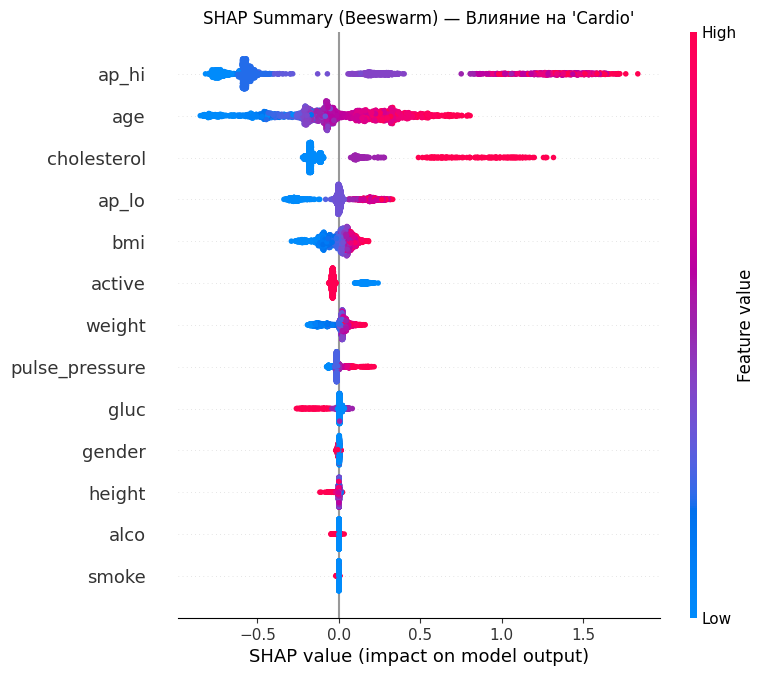

In [ ]:
# 1. Summary Plot (Beeswarm) — Глобальная важность
shap.summary_plot(shap_matrix, X_test, show=False)
plt.title("SHAP Summary (Beeswarm) — Влияние на 'Cardio'")
plt.show()

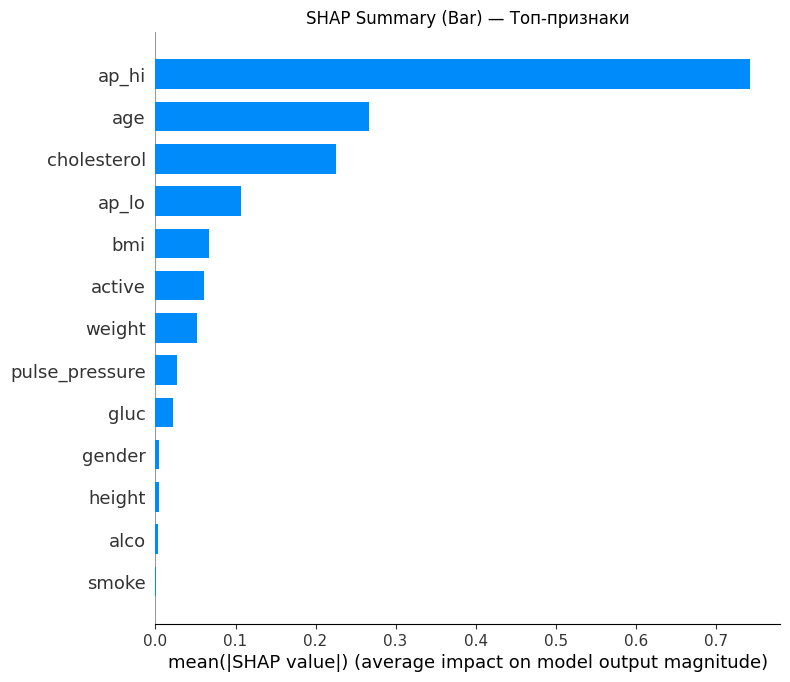

In [ ]:
# 2. Summary Plot (Bar) — Топ-признаки
shap.summary_plot(shap_matrix, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary (Bar) — Топ-признаки")
plt.show()

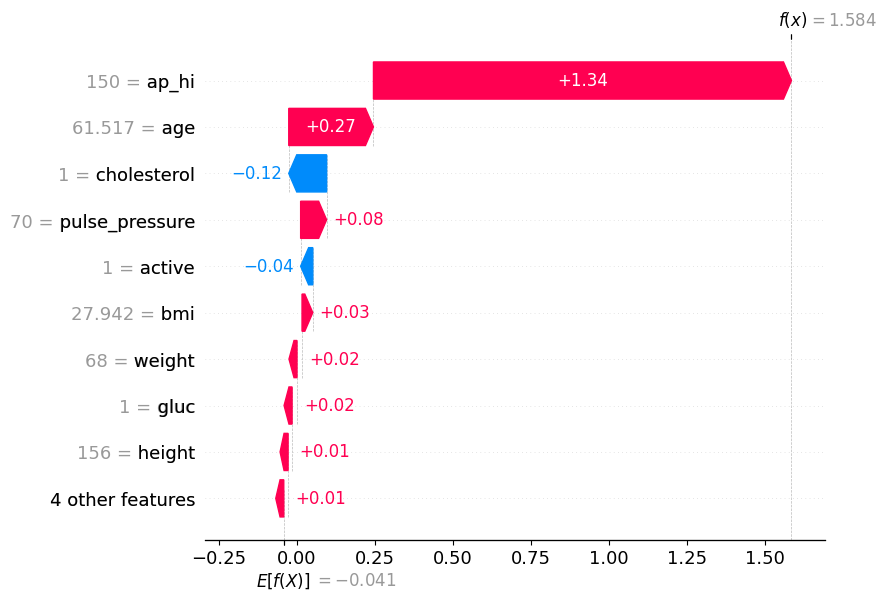

In [ ]:
# 3. Waterfall Plot — Детальное разложение
shap.waterfall_plot(
    shap.Explanation(
        values=shap_matrix[idx],
        base_values=expected_value,
        data=X_test.iloc[idx]
    ),
    max_display=10
)

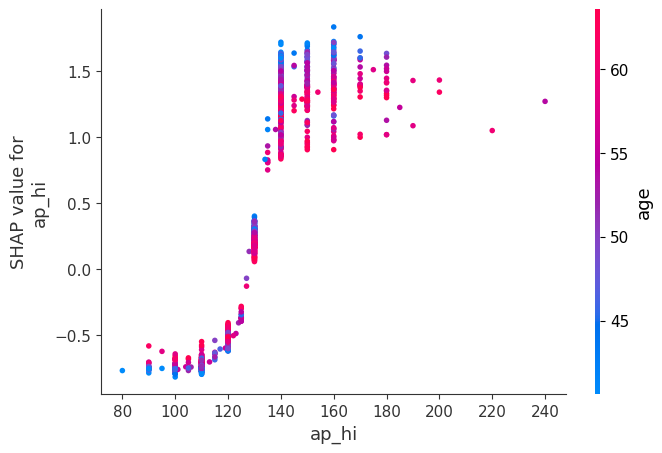

In [ ]:
# 5. Dependence Plot — Взаимосвязь признаков
shap.dependence_plot("ap_hi", shap_matrix, X_test, interaction_index="age")


ИНТЕРПРЕТАЦИЯ ЭКЗЕМПЛЯРА #1 (класс: Болен)

LIME ОБЪЯСНЕНИЕ ДЛЯ НАБЛЮДЕНИЯ #1
Фактический класс: 0
Предсказанный класс: 0
Вероятности: [Здоров: 0.627, Болен: 0.373]


### Визуализация успешно показана в Colab!

SHAP Force Plot (локально):



SHAP Waterfall (пошаговое влияние):


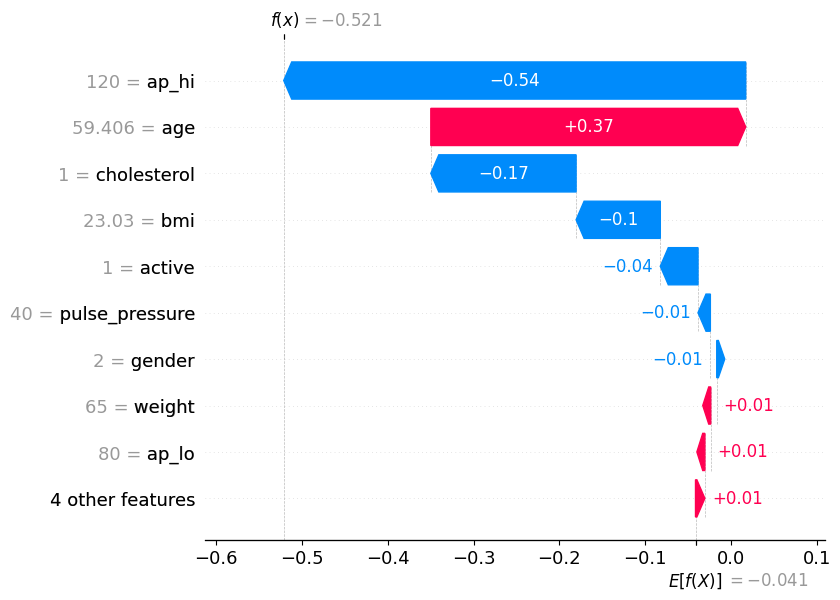

In [ ]:
def full_interpret(idx):
    print(f"\n{'='*60}")
    print(f"ИНТЕРПРЕТАЦИЯ ЭКЗЕМПЛЯРА #{idx} (класс: Болен)")
    print(f"{'='*60}")

    # --- LIME ---
    lime_explain_model(idx, num_features=8)  # Исправлено на функцию для CatBoost

    # --- SHAP Force Plot ---
    print("\nSHAP Force Plot (локально):")
    shap.initjs()
    display(shap.force_plot(
        base_value=expected_value,
        shap_values=shap_matrix[idx],
        features=X_test.iloc[idx],
        feature_names=X_test.columns.tolist(),
        matplotlib=False
    ))

    # --- SHAP Waterfall ---
    print("\nSHAP Waterfall (пошаговое влияние):")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_matrix[idx],
            base_values=expected_value,
            data=X_test.iloc[idx],
            feature_names=X_test.columns.tolist()
        ),
        max_display=10
    )

# === Пример использования ===
full_interpret(1)